In [1]:
!pip install torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

Using device: cuda


100%|██████████| 26.4M/26.4M [00:00<00:00, 113MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 4.08MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 59.6MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 17.2MB/s]



=== Regular Vision Transformer (Full Fine-tuning) ===
Total Parameters: 2,684,554
Trainable Parameters: 2,684,554
Trainable Parameters Percentage: 100.00%
Training VisionTransformer
Epoch 1/10 - Train Loss: 0.8787, Train Acc: 68.01% - Test Loss: 0.6441, Test Acc: 76.94%
Epoch 2/10 - Train Loss: 0.5125, Train Acc: 81.28% - Test Loss: 0.4525, Test Acc: 83.10%
Epoch 3/10 - Train Loss: 0.4356, Train Acc: 84.16% - Test Loss: 0.4457, Test Acc: 83.86%
Epoch 4/10 - Train Loss: 0.4003, Train Acc: 85.25% - Test Loss: 0.4012, Test Acc: 85.57%
Epoch 5/10 - Train Loss: 0.3753, Train Acc: 86.22% - Test Loss: 0.3645, Test Acc: 86.62%
Epoch 6/10 - Train Loss: 0.3506, Train Acc: 87.15% - Test Loss: 0.3497, Test Acc: 87.30%
Epoch 7/10 - Train Loss: 0.3416, Train Acc: 87.42% - Test Loss: 0.3535, Test Acc: 87.31%
Epoch 8/10 - Train Loss: 0.3257, Train Acc: 87.93% - Test Loss: 0.3537, Test Acc: 86.67%
Epoch 9/10 - Train Loss: 0.3260, Train Acc: 87.90% - Test Loss: 0.3555, Test Acc: 86.96%
Epoch 10/10 - Tr

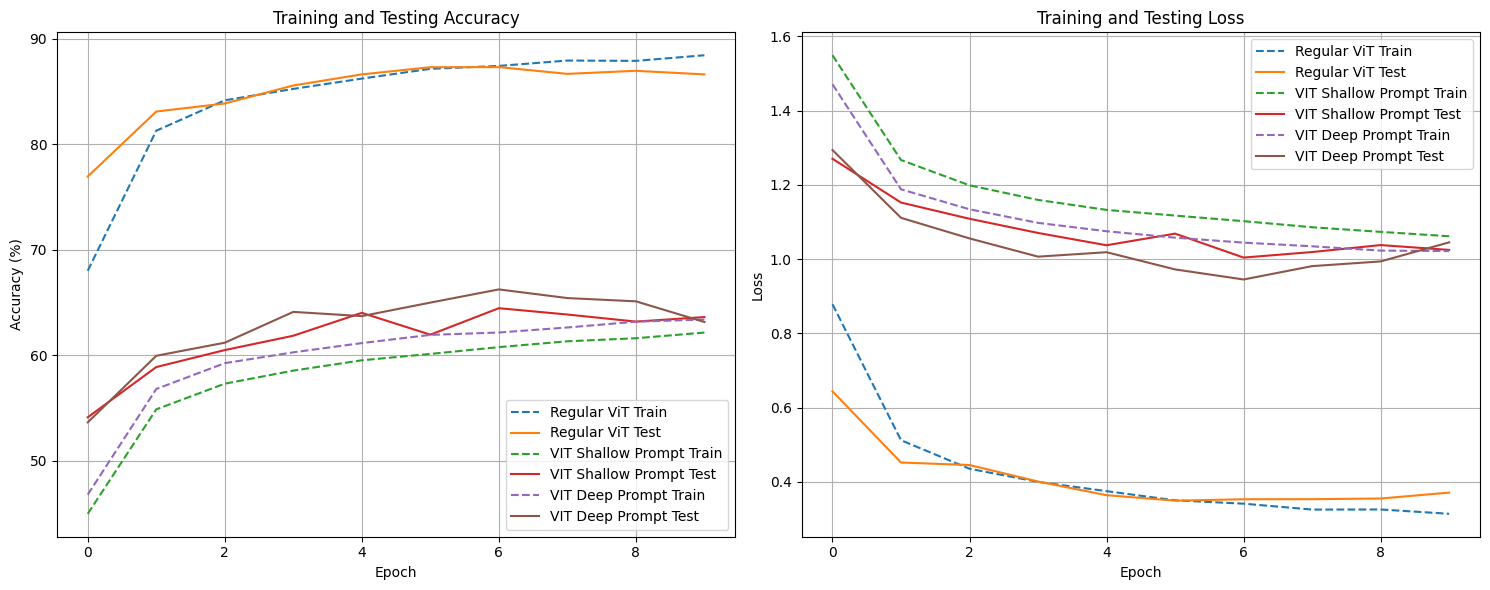

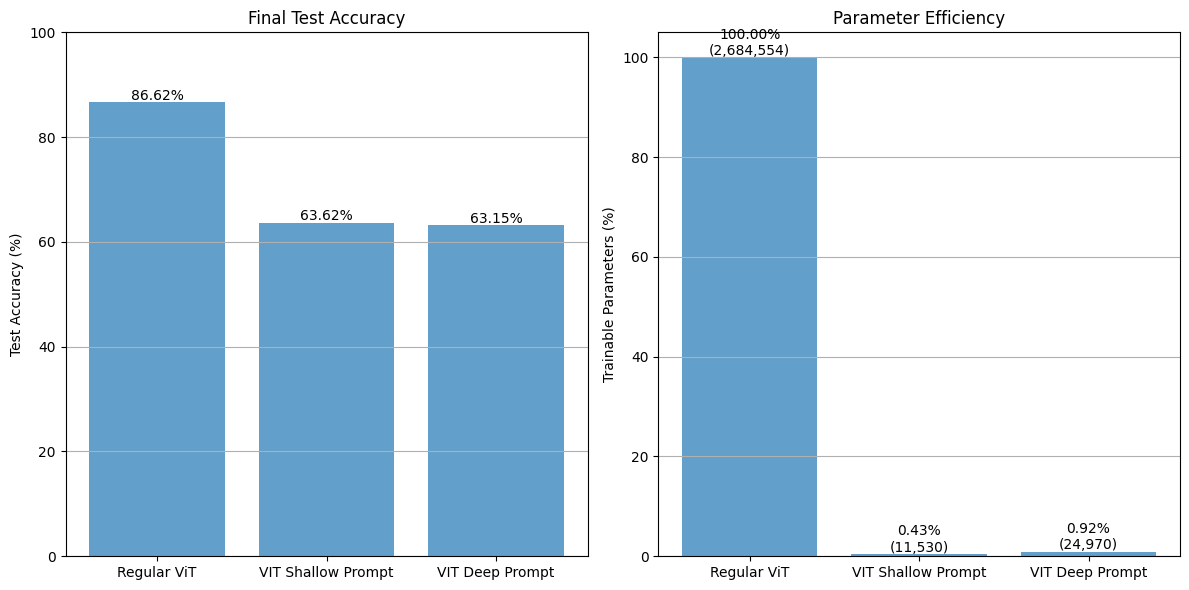


Visualizing Regular ViT predictions:


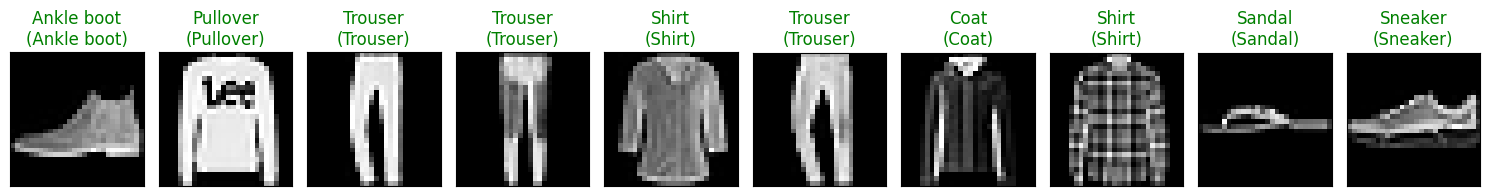


Visualizing VIT Shallow Prompt predictions:


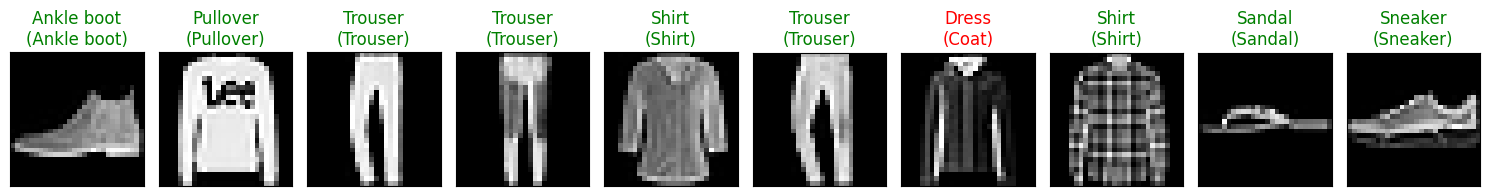


Visualizing VIT Deep Prompt predictions:


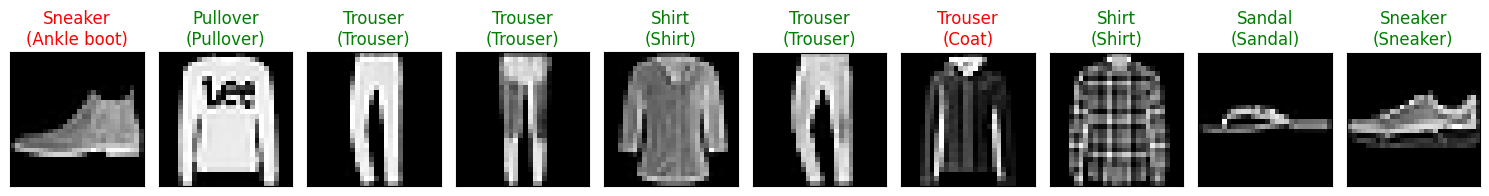


=== Final Results Summary ===
Model                Test Accuracy   Trainable Params     % of Total
-----------------------------------------------------------------
Regular ViT          86.62%           2,684,554      100.00%
VIT Shallow Prompt   63.62%           11,530      0.43%
VIT Deep Prompt      63.15%           24,970      0.92%


In [2]:
 import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

torch.manual_seed(3)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(3)

#fashion MNIST classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#ViT architecture
class VisionTransformer(nn.Module):
    def __init__(
        self,
        image_size=28, patch_size=4, in_channels=1,
        num_classes=10, embed_dim=192, depth=6,
        num_heads=8, mlp_ratio=4.0, dropout=0.1,
    ):
        super().__init__()

        self.image_size = image_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.depth = depth
        self.num_heads = num_heads
        self.mlp_ratio = mlp_ratio
        self.dropout = dropout

        #number of patches
        self.num_patches = (image_size // patch_size) ** 2

        #patch embedding
        self.pt_embed = nn.Conv2d(
            in_channels, embed_dim,
            kernel_size=patch_size, stride=patch_size
        )

        #prompt token
        self.p_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        #position embeddings
        self.ps_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))

        self.transformer_layers = nn.ModuleList([
            TransformerEncoderLayer(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(embed_dim)

        #classification head
        self.head = nn.Linear(embed_dim, num_classes)

        #weight initialization
        self._init_weights()

    def _init_weights(self):
        # init patch embeddings
        nn.init.normal_(self.ps_embed, std=0.02)
        # init projection matrices
        nn.init.normal_(self.p_token, std=0.02)

        #apply general weight
        self.apply(self._init_weights_general)

    def _init_weights_general(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        #x.shape= [B, C, H, W]
        batch_size = x.shape[0]

        #pt_embed= [B, E, gh, gw]
        x = self.pt_embed(x)

        #x.flatted= [B, E, N]
        x = x.flatten(2)

        #x.transpose= [B, N, E]
        x = x.transpose(1, 2)

        p_tokens = self.p_token.expand(batch_size, -1, -1)
        x = torch.cat((p_tokens, x), dim=1)

        #add ps_embed
        x = x + self.ps_embed

        #pass through transformer layers
        for layer in self.transformer_layers:
            x = layer(x)

        #layer normalization
        x = self.norm(x)

        #first propmt token
        x = x[:, 0]
        x = self.head(x)

        return x


#Visual Prompt Tuning
class ViTWithPrompt(nn.Module):
    def __init__(
        self,
        image_size=28, patch_size=4, in_channels=1,
        num_classes=10, embed_dim=192, depth=6,
        num_heads=8, mlp_ratio=4.0, dropout=0.1,
        prompt_length=10, prompt_mode='deep',  #deep first, then shallow
    ):
        super().__init__()

        self.image_size = image_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.depth = depth
        self.num_heads = num_heads
        self.mlp_ratio = mlp_ratio
        self.dropout = dropout

        #parameters
        self.prompt_length = prompt_length
        self.prompt_mode = prompt_mode


        #number of patches
        self.num_patches = (image_size // patch_size) ** 2

        #patth embedding
        self.pt_embed = nn.Conv2d(
            in_channels, embed_dim,
            kernel_size=patch_size, stride=patch_size)




        #prompt token
        self.p_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        #pos embeddings for patches
        self.ps_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))

        if self.prompt_mode == 'deep':
            #prompt each transformer layer
            self.prompts = nn.ParameterList([
                nn.Parameter(torch.zeros(1, prompt_length, embed_dim))
                for _ in range(depth)
            ])
        else: #'shallow'
            #only prompt the first layer
            self.prompts = nn.Parameter(torch.zeros(1, prompt_length, embed_dim))

        #encoder layers
        self.transformer_layers = nn.ModuleList([
            TransformerEncoderLayer(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        self._init_weights()

    def _init_weights(self):
        nn.init.normal_(self.ps_embed, std=0.02)
        nn.init.normal_(self.p_token, std=0.02)

        #prompts
        if self.prompt_mode == 'deep':
            for prompt in self.prompts:
                nn.init.normal_(prompt, std=0.02)
        else:
            nn.init.normal_(self.prompts, std=0.02)

        #apply general weights
        self.apply(self._init_weights_general)

    def _init_weights_general(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pt_embed(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)

        p_tokens = self.p_token.expand(batch_size, -1, -1)
        x = torch.cat((p_tokens, x), dim=1)

        #ad ps_embed
        x = x + self.ps_embed

        #  Go through transformer layers with prompts

        for i, layer in enumerate(self.transformer_layers):

            if self.prompt_mode == 'deep':

                # append prompt tokens specific to this layer
                prompt = self.prompts[i].expand(batch_size, -1, -1)


                # implement prompt after the CLS token
                x_with_prompt = torch.cat((x[:, 0:1], prompt, x[:, 1:]), dim=1)

                x = layer(x_with_prompt)

            elif self.prompt_mode == 'shallow' and i == 0:

                # prompt only the first layer
                prompt = self.prompts.expand(batch_size, -1, -1)

                x_with_prompt = torch.cat((x[:, 0:1], prompt, x[:, 1:]), dim=1)

                x = layer(x_with_prompt)

            else:

                x = layer(x)

        x = self.norm(x)
        x = x[:, 0]
        x = self.head(x)

        return x


class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.0):
        super().__init__()

        self.norm1 = nn.LayerNorm(embed_dim)


        self.attn = nn.MultiheadAttention(embed_dim, num_heads,
                                          dropout=dropout, batch_first=True)

        self.norm2 = nn.LayerNorm(embed_dim)

        mlp_hidden_dim = int(embed_dim * mlp_ratio)

        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_dim), nn.GELU(),
            nn.Dropout(dropout), nn.Linear(mlp_hidden_dim, embed_dim),
            nn.Dropout(dropout))

    def forward(self, x):
        # pre-norm architecture for better training stability
        normalized_x = self.norm1(x)
        attn_output, _ = self.attn(normalized_x, normalized_x, normalized_x)
        x = x + attn_output  # res connection

        normalized_x = self.norm2(x)
        mlp_output = self.mlp(normalized_x)
        x = x + mlp_output  #res connection
        return x


#data loading and preprocessing
def load_fashion_mnist(batch_size=64):
    # dta transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    #load dataset
    train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

    #test & train dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader


#training
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    #statistics & function calling
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)
        #print(inputs, labels)

        #zero parameter gradients
        optimizer.zero_grad()

        #Forward pass
        outputs = model(inputs)
        #loss
        loss = criterion(outputs, labels)

        #Backward pass
        loss.backward()
        #optimize
        optimizer.step()

        #update statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

#Evaluation function
def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:

            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            #print("Run Loss: ", running_loss, "loss: ", loss,"outputs & labels: " outputs, ","labels)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

#coutn parameters
def count_parameters(model, only_trainable=True):
    if only_trainable:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in model.parameters())

#prediction visualization
def visualize_predictions(model, test_loader, classes, device, num_images=10):
    model.eval()
    with torch.no_grad():
        dataiter = iter(test_loader)
        images, labels = next(dataiter)
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        #move to CPU for visualization
        images = images.cpu()
        labels = labels.cpu()
        predicted = predicted.cpu()

        #ploting
        fig = plt.figure(figsize=(15, 4))
        for idx in range(num_images):

            ax = fig.add_subplot(1, num_images,
                                 idx+1, xticks=[], yticks=[])

            img = images[idx].numpy().transpose(1, 2, 0)
            img = img / 2 + 0.5

            plt.imshow(img.squeeze(), cmap='gray')

            title_color = "green" if predicted[idx] == labels[idx] else "red"
            ax.set_title(f"{classes[predicted[idx]]}\n({classes[labels[idx]]})",
                        color=title_color)


        plt.tight_layout()
        plt.show()


#training loop
def train_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=10):
    print(f"Training {model.__class__.__name__}")

    train_losses = []
    train_accs = []

    test_losses = []
    test_accs = []

    for e in range(num_epochs):

        #Train
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        #Evaluate
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f"Epoch {e+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

    return train_losses, train_accs, test_losses, test_accs


#VIT vs shallow and deep VPT
def compare_models(train_loader, test_loader, device, num_epochs=10):
    results = {}

    # regular Vision Transformer
    print("\n=== Regular Vision Transformer (Full Fine-tuning) ===")
    vit_model = VisionTransformer().to(device)

    #count parameters
    total_params = count_parameters(vit_model, only_trainable=False)
    trainable_params = count_parameters(vit_model, only_trainable=True)

    print(f"Total Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    print(f"Trainable Parameters Percentage: {trainable_params / total_params * 100:.2f}%")

    vit_criterion = nn.CrossEntropyLoss()
    vit_optimizer = optim.Adam(vit_model.parameters(), lr=0.001)

    vit_results = train_model(
        vit_model, train_loader, test_loader, vit_criterion,
        vit_optimizer, device, num_epochs
    )

    results['Regular ViT'] = {
        'model': vit_model,
        'train_losses': vit_results[0],
        'train_accs': vit_results[1],
        'test_losses': vit_results[2],
        'test_accs': vit_results[3],
        'total_params': total_params,
        'trainable_params': trainable_params
    }

    #Shallow Prompting
    print("\n=== Vision Transformer with Shallow Prompting ===")
    vit_shallow = ViTWithPrompt(
        prompt_mode='shallow',
        prompt_length=50  #tested: larger prompt length gave better performance but took alot more time
    ).to(device)

    #only train prompts and head, freeze the rest
    for name, param in vit_shallow.named_parameters():
        if 'prompt' not in name and 'head' not in name:
            param.requires_grad = False

    #count parameters
    total_params = count_parameters(vit_shallow, only_trainable=False)
    trainable_params = count_parameters(vit_shallow, only_trainable=True)

    print(f"Total Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    print(f"Trainable Parameters Percentage: {trainable_params / total_params * 100:.2f}%")

    vit_shallow_criterion = nn.CrossEntropyLoss()
    vit_shallow_optimizer = optim.Adam(
        filter(lambda p: p.requires_grad,vit_shallow.parameters()),lr=0.001)

    vit_shallow_results = train_model(
        vit_shallow, train_loader, test_loader, vit_shallow_criterion,
        vit_shallow_optimizer, device, num_epochs
    )

    results['VIT Shallow Prompt'] = {
        'model': vit_shallow,
        'train_losses': vit_shallow_results[0], 'train_accs': vit_shallow_results[1],
        'test_losses': vit_shallow_results[2], 'test_accs': vit_shallow_results[3],
        'total_params': total_params, 'trainable_params': trainable_params
    }

    #deep prompting
    print("\n=== Vision Transformer with Deep Prompting ===")
    vit_deep = ViTWithPrompt(
        prompt_mode='deep', prompt_length=20
        # smaller prompt length for each layer, takes too long if p_length is too big on each layer
    ).to(device)

    #only train prompts and head, freeze the rest
    for name, param in vit_deep.named_parameters():
        if 'prompt' not in name and 'head' not in name: param.requires_grad = False

    #count parameters
    total_params = count_parameters(vit_deep, only_trainable=False)
    trainable_params = count_parameters(vit_deep, only_trainable=True)

    print(f"Total Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    print(f"Trainable Parameters Percentage: {trainable_params / total_params * 100:.2f}%")

    vit_deep_criterion = nn.CrossEntropyLoss()
    vit_deep_optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, vit_deep.parameters()), lr=0.001)

    vit_deep_results = train_model(
        vit_deep, train_loader, test_loader, vit_deep_criterion,
        vit_deep_optimizer, device, num_epochs)

    results['VIT Deep Prompt'] = {
        'model': vit_deep,
        'train_losses': vit_deep_results[0],
        'train_accs': vit_deep_results[1],
        'test_losses': vit_deep_results[2],
        'test_accs': vit_deep_results[3],
        'total_params': total_params,
        'trainable_params': trainable_params
    }
    return results


#plot results
def plot_results(results):
    #accuracy comparison
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    for model_name, model_results in results.items():
        plt.plot(model_results['train_accs'], '--', label=f'{model_name} Train')
        plt.plot(model_results['test_accs'], '-', label=f'{model_name} Test')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')

    plt.title('Training and Testing Accuracy')

    plt.legend()
    plt.grid(True)

    #loss comparison
    plt.subplot(1, 2, 2)
    for model_name, model_results in results.items():
        plt.plot(model_results['train_losses'], '--', label=f'{model_name} Train')
        plt.plot(model_results['test_losses'], '-', label=f'{model_name} Test')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.title('Training and Testing Loss')

    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    #final performance
    model_names = list(results.keys())
    final_test_accs = [results[model_name]['test_accs'][-1] for model_name in model_names]
    # parameter comparison
    trainable_params = [results[model_name]['trainable_params'] for model_name in model_names]
    param_percentages = [results[model_name]['trainable_params'] / results[model_name]['total_params'] * 100 for model_name in model_names]

    plt.figure(figsize=(12, 6))

    # accuracy vs trainable parameters
    plt.subplot(1, 2, 1)
    bars = plt.bar(model_names, final_test_accs, alpha=0.7)

    for i, bar in enumerate(bars):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.5,
            f'{final_test_accs[i]:.2f}%',
            ha='center'
        )

    plt.ylabel('Test Accuracy (%)')
    plt.title('Final Test Accuracy')

    plt.ylim(0, 100)
    plt.grid(axis='y')

    #trainable parameter percentage
    plt.subplot(1, 2, 2)
    bars = plt.bar(model_names, param_percentages, alpha=0.7)

    for i, bar in enumerate(bars):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.5,
            f'{param_percentages[i]:.2f}%\n({trainable_params[i]:,})',
            ha='center'
        )

    plt.ylabel('Trainable Parameters (%)')
    plt.title('Parameter Efficiency')
    plt.grid(axis='y')

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    train_loader, test_loader = load_fashion_mnist(batch_size=128)

    #compare models
    results = compare_models(train_loader, test_loader, device, num_epochs=10)

    #plot results
    plot_results(results)

    #each model's prediction visualization
    for model_name, model_info in results.items():
        print(f"\nVisualizing {model_name} predictions:")
        visualize_predictions(model_info['model'], test_loader, classes, device)

    # final summary
    print("\n=== Final Results Summary ===")
    print(f"{'Model':<20} {'Test Accuracy':<15} {'Trainable Params':<20} {'% of Total':<10}")
    print("-" * 65)

    for model_name, model_info in results.items():
        final_acc = model_info['test_accs'][-1]
        trainable = model_info['trainable_params']
        total = model_info['total_params']
        percentage = trainable / total * 100

        print(f"{model_name:<20} {final_acc:.2f}%{'':<10} {trainable:,}{'':<5} {percentage:.2f}%")